In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/CSE6250/new/BiteNet-Muwu/

Mounted at /content/drive
/content/drive/MyDrive/CSE6250/new/BiteNet-Muwu


In [2]:
from utils.configs import cfg
from utils.record_log import RecordLog
import numpy as np
from BiteNet.model_mh import BiteNet as Model
import os
from dataset.dataset_full import VisitDataset
import warnings
import heapq
import operator
import tensorflow as tf
from utils.evaluation import ConceptEvaluation as CodeEval, \
    EvaluationTemplate as Evaluation
warnings.filterwarnings('ignore')
logging = RecordLog()


In [ ]:
import pickle
with open('visit_dataset.pkl', 'rb') as f:
    loaded_dataset = pickle.load(f)


In [4]:
from torch.utils.data import Dataset, DataLoader
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class VisitDatasetTorch(Dataset):
    def __init__(self, context_codes, intervals, labels_1, labels_2):
        self.context_codes = torch.tensor(context_codes, dtype=torch.long).to(device)
        self.intervals = torch.tensor(intervals, dtype=torch.long).to(device)
        self.labels_1 = torch.tensor(labels_1, dtype=torch.float32).to(device)
        self.labels_2 = torch.tensor(labels_2, dtype=torch.float32).to(device)

    def __len__(self):
        return len(self.context_codes)

    def __getitem__(self, idx):
        return (self.context_codes[idx], self.intervals[idx], self.labels_1[idx], self.labels_2[idx])


train_dataset = VisitDatasetTorch(
    loaded_dataset.train_context_codes,
    loaded_dataset.train_intervals,
    loaded_dataset.train_labels_1,
    loaded_dataset.train_labels_2
)


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)

In [41]:

import torch
import torch.nn as nn


class BiteNet(nn.Module):
    def __init__(self, dataset, embedding_size=128, num_heads=8, num_layers=2, dropout=0.1):
        super(BiteNet, self).__init__()

        self.embedding_size = embedding_size
        self.num_heads = num_heads
        self.num_layers = num_layers
        self.dropout = dropout

        self.vocabulary_size = len(dataset.dictionary)
        self.digit3_size = len(dataset.dictionary_3digit)
        self.n_visits = dataset.valid_visits
        self.n_codes = dataset.max_len_visit
        self.n_intervals = dataset.days_size
        self.forward_attention_pooling = AttentionPooling(self.embedding_size)
        self.backward_attention_pooling = AttentionPooling(self.embedding_size)


        self.code_embedding = nn.Embedding(self.vocabulary_size, self.embedding_size)
        self.interval_embedding = nn.Embedding(self.n_intervals, self.embedding_size)


        code_attention_layer = nn.TransformerEncoderLayer(
            d_model=self.embedding_size,
            nhead=self.num_heads,
            dim_feedforward=self.embedding_size * 4,
            dropout=self.dropout,
            activation='relu'
        )
        self.code_attention_encoder = nn.TransformerEncoder(code_attention_layer, num_layers=self.num_layers)


        forward_attention_layer = nn.TransformerEncoderLayer(
            d_model=self.embedding_size,
            nhead=self.num_heads,
            dim_feedforward=self.embedding_size * 4,
            dropout=self.dropout,
            activation='relu'
        )
        self.forward_attention_encoder = nn.TransformerEncoder(forward_attention_layer, num_layers=self.num_layers)


        backward_attention_layer = nn.TransformerEncoderLayer(
            d_model=self.embedding_size,
            nhead=self.num_heads,
            dim_feedforward=self.embedding_size * 4,
            dropout=self.dropout,
            activation='relu'
        )
        self.backward_attention_encoder = nn.TransformerEncoder(backward_attention_layer, num_layers=self.num_layers)


        self.ffn = nn.Sequential(
            nn.Linear(self.embedding_size * 2, self.embedding_size),
            nn.ReLU(),
            nn.Dropout(self.dropout),
            nn.Linear(self.embedding_size, self.digit3_size),
        )


        self.readmission_classifier = nn.Sequential(
            nn.Linear(self.embedding_size * 2, 1),
        )

    def generate_diagonal_mask(self, size, direction="forward"):

        mask = torch.ones(size, size)
        if direction == "forward":
            mask = torch.triu(mask, diagonal=1)
        elif direction == "backward":
            mask = torch.tril(mask, diagonal=-1)
        return mask.masked_fill(mask == 1, float('-inf')).masked_fill(mask == 0, 0)

    def forward(self, code_inputs, interval_inputs, predict_type="dx"):

        code_embedded = self.code_embedding(code_inputs)

        batch_size, n_visits, n_codes, embedding_size = code_embedded.shape
        code_embedded = torch.mean(code_embedded, dim=2)

        code_embedded = code_embedded.view(-1, n_visits, embedding_size).permute(1, 0, 2)


        code_mask = self.generate_diagonal_mask(n_visits).to(code_embedded.device)
        code_embedded = self.code_attention_encoder(code_embedded, mask=code_mask)


        code_embedded = code_embedded.permute(1, 0, 2).view(batch_size, n_visits, embedding_size)


        interval_embedded = self.interval_embedding(interval_inputs)

        visit_embedding = code_embedded + interval_embedded

        visit_embedding = visit_embedding.permute(1, 0, 2)

        forward_mask = self.generate_diagonal_mask(n_visits, direction="forward").to(visit_embedding.device)
        backward_mask = self.generate_diagonal_mask(n_visits, direction="backward").to(visit_embedding.device)


        forward_output = self.forward_attention_encoder(visit_embedding, mask=forward_mask)


        backward_output = self.backward_attention_encoder(visit_embedding, mask=backward_mask)


        forward_output = forward_output.permute(1, 0, 2)
        backward_output = backward_output.permute(1, 0, 2)

        forward_pooled = self.forward_attention_pooling(forward_output)
        backward_pooled = self.backward_attention_pooling(backward_output)

        global_features = torch.cat([forward_pooled, backward_pooled], dim=1)


        if predict_type == "dx":
            return self.ffn(global_features)
        elif predict_type == "re":
            return self.readmission_classifier(global_features)

In [7]:

class AttentionPooling(nn.Module):
    def __init__(self, embedding_size):
        super(AttentionPooling, self).__init__()
        self.W1 = nn.Linear(embedding_size, embedding_size)
        self.W2 = nn.Linear(embedding_size, 1)

    def forward(self, inputs, mask=None):

        scores = self.W2(torch.tanh(self.W1(inputs))).squeeze(-1)


        if mask is not None:
            scores = scores.masked_fill(mask == 0, float('-inf'))


        weights = torch.softmax(scores, dim=1)


        outputs = torch.sum(weights.unsqueeze(-1) * inputs, dim=1)
        return outputs

Epoch 1, Train Loss: 0.6679, Train Acc: 0.6064, Val Loss: 0.6518, Val Acc: 0.6633
Epoch 2, Train Loss: 0.6416, Train Acc: 0.6807, Val Loss: 0.6264, Val Acc: 0.7114
Epoch 3, Train Loss: 0.6188, Train Acc: 0.7198, Val Loss: 0.6027, Val Acc: 0.7470
Epoch 4, Train Loss: 0.5972, Train Acc: 0.7463, Val Loss: 0.5813, Val Acc: 0.7716
Epoch 5, Train Loss: 0.5777, Train Acc: 0.7662, Val Loss: 0.5625, Val Acc: 0.7938
Epoch 6, Train Loss: 0.5594, Train Acc: 0.7812, Val Loss: 0.5436, Val Acc: 0.8026
Epoch 7, Train Loss: 0.5416, Train Acc: 0.7923, Val Loss: 0.5246, Val Acc: 0.8088
Epoch 8, Train Loss: 0.5230, Train Acc: 0.8014, Val Loss: 0.5063, Val Acc: 0.8131
Epoch 9, Train Loss: 0.5064, Train Acc: 0.8099, Val Loss: 0.4894, Val Acc: 0.8159
Epoch 10, Train Loss: 0.4901, Train Acc: 0.8175, Val Loss: 0.4737, Val Acc: 0.8203
Epoch 11, Train Loss: 0.4759, Train Acc: 0.8238, Val Loss: 0.4591, Val Acc: 0.8273
Epoch 12, Train Loss: 0.4614, Train Acc: 0.8303, Val Loss: 0.4452, Val Acc: 0.8357
Epoch 13, Tra

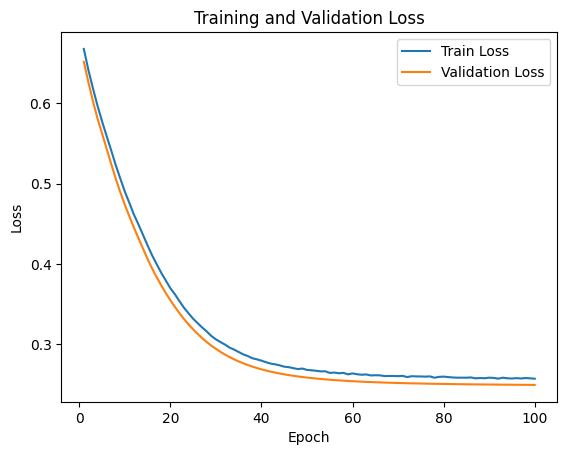

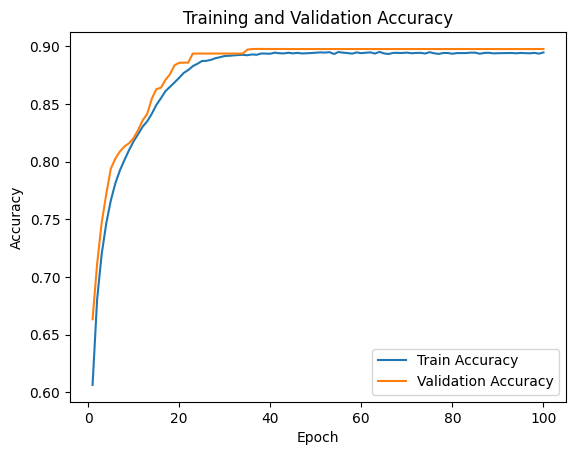

In [91]:
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt


model = BiteNet(dataset=loaded_dataset, embedding_size=128, num_heads=8, num_layers=2, dropout=0.1)
optimizer = optim.Adam(model.parameters(), lr=0.00001)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.BCEWithLogitsLoss()


train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(100):
    model.train()
    train_loss_sum = 0
    train_correct = 0
    train_total = 0

    for batch in train_loader:

        context_codes, intervals, labels_1, labels_2 = batch


        context_codes = context_codes.to(device)
        intervals = intervals.to(device)
        labels_1 = labels_1.to(device)


        outputs = model(context_codes, intervals, predict_type="dx")
        loss = criterion(outputs, labels_1)
        train_loss_sum += loss.item()


        predicted = (torch.sigmoid(outputs) > 0.5).float()
        train_correct += (predicted == labels_1).sum().item()
        train_total += labels_1.numel()


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_losses.append(train_loss_sum / len(train_loader))
    train_accuracies.append(train_correct / train_total)


    model.eval()
    val_loss_sum = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for batch in test_loader:

            context_codes, intervals, labels_1, labels_2 = batch


            context_codes = context_codes.to(device)
            intervals = intervals.to(device)
            labels_1 = labels_1.to(device)


            outputs = model(context_codes, intervals, predict_type="dx")
            val_loss = criterion(outputs, labels_1)
            val_loss_sum += val_loss.item()


            predicted = (torch.sigmoid(outputs) > 0.5).float()
            val_correct += (predicted == labels_1).sum().item()
            val_total += labels_1.numel()


    val_losses.append(val_loss_sum / len(test_loader))
    val_accuracies.append(val_correct / val_total)


    print(f"Epoch {epoch + 1}, Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.4f}, "
          f"Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.4f}")


plt.figure()
plt.plot(range(1, 101), train_losses, label='Train Loss')
plt.plot(range(1, 101), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


plt.figure()
plt.plot(range(1, 101), train_accuracies, label='Train Accuracy')
plt.plot(range(1, 101), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [93]:
model.eval()

correct = 0
total = 0

with torch.no_grad():
    for batch in test_loader:
        context_codes, intervals, labels_1, labels_2 = batch
        context_codes, intervals, labels_1, labels_2 = (
            context_codes.to(device),
            intervals.to(device),
            labels_1.to(device),
            labels_2.to(device),
        )


        outputs = model(context_codes, intervals, predict_type="dx")


        predicted = (torch.sigmoid(outputs) > 0.5).float()


        correct += (predicted == labels_1).sum().item()
        total += labels_1.numel()


accuracy = correct / total
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.8976


In [64]:
import torch

def precision_at_k(outputs, labels, k=5):


    topk_indices = torch.topk(outputs, k=k, dim=1).indices


    precision_sum = 0


    for i in range(labels.size(0)):
        true_labels = torch.nonzero(labels[i], as_tuple=True)[0]
        predicted_labels = topk_indices[i]

        correct_count = len(set(predicted_labels.tolist()) & set(true_labels.tolist()))


        precision_sum += correct_count / k


    return precision_sum / labels.size(0)

In [85]:
model.eval()


k_list = [5, 10, 15, 20, 25, 30]
DP_list = []
for k in k_list:
    precision_k_sum = 0
    with torch.no_grad():
        for batch in test_loader:
            context_codes, intervals, labels_1, labels_2 = batch
            context_codes, intervals, labels_1 = (
                context_codes.to(device),
                intervals.to(device),
                labels_1.to(device),
            )


            outputs = model(context_codes, intervals, predict_type="dx")
            outputs = torch.sigmoid(outputs)


            precision_k = precision_at_k(outputs, labels_1, k=k)
            precision_k_sum += precision_k


    average_precision_k = precision_k_sum / len(test_loader)
    print(f"Diagnosis Precision@5: {average_precision_k:.4f}")
    DP_list.append(average_precision_k)


Diagnosis Precision@5: 0.6208
Diagnosis Precision@5: 0.5258
Diagnosis Precision@5: 0.4585
Diagnosis Precision@5: 0.4098
Diagnosis Precision@5: 0.3704
Diagnosis Precision@5: 0.3343


In [86]:
DP_list

[0.620776098901099,
 0.5257554945054945,
 0.45845924908424907,
 0.40981284340659335,
 0.37037774725274725,
 0.33429487179487183]

Epoch 1, Train Loss: 0.6568, Train Acc: 0.5894, Val Loss: 0.5383, Val Acc: 0.7947
Epoch 2, Train Loss: 0.5147, Train Acc: 0.7947, Val Loss: 0.5080, Val Acc: 0.7947
Epoch 3, Train Loss: 0.5082, Train Acc: 0.7947, Val Loss: 0.5084, Val Acc: 0.7947
Epoch 4, Train Loss: 0.5091, Train Acc: 0.7947, Val Loss: 0.5077, Val Acc: 0.7947
Epoch 5, Train Loss: 0.5070, Train Acc: 0.7947, Val Loss: 0.5068, Val Acc: 0.7947
Epoch 6, Train Loss: 0.5058, Train Acc: 0.7947, Val Loss: 0.5063, Val Acc: 0.7947
Epoch 7, Train Loss: 0.5087, Train Acc: 0.7947, Val Loss: 0.5062, Val Acc: 0.7947
Epoch 8, Train Loss: 0.5068, Train Acc: 0.7947, Val Loss: 0.5054, Val Acc: 0.7947
Epoch 9, Train Loss: 0.5056, Train Acc: 0.7947, Val Loss: 0.5053, Val Acc: 0.7947
Epoch 10, Train Loss: 0.5073, Train Acc: 0.7947, Val Loss: 0.5048, Val Acc: 0.7947
Epoch 11, Train Loss: 0.5046, Train Acc: 0.7947, Val Loss: 0.5042, Val Acc: 0.7947
Epoch 12, Train Loss: 0.5061, Train Acc: 0.7947, Val Loss: 0.5038, Val Acc: 0.7947
Epoch 13, Tra

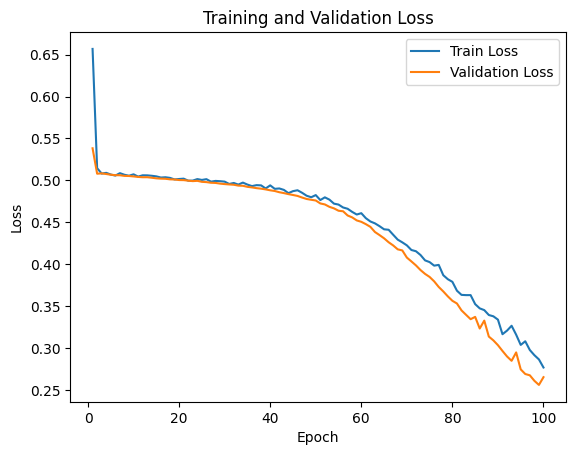

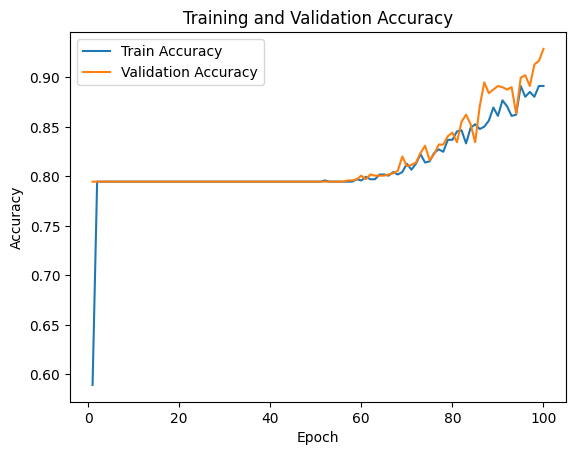

In [87]:
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt

model = BiteNet(dataset=loaded_dataset, embedding_size=128, num_heads=8, num_layers=2, dropout=0.1)
optimizer = optim.Adam(model.parameters(), lr=0.00001)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


criterion = nn.BCEWithLogitsLoss()


train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []


for epoch in range(100):
    model.train()
    train_loss_sum = 0
    train_correct = 0
    train_total = 0

    for batch in train_loader:

        context_codes, intervals, labels_1, labels_2 = batch


        context_codes = context_codes.to(device)
        intervals = intervals.to(device)
        labels_2 = labels_2.to(device)


        outputs = model(context_codes, intervals, predict_type="re")
        loss = criterion(outputs, labels_2)
        train_loss_sum += loss.item()


        predicted = (torch.sigmoid(outputs) > 0.5).float()
        train_correct += (predicted == labels_2).sum().item()
        train_total += labels_2.numel()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


    train_losses.append(train_loss_sum / len(train_loader))
    train_accuracies.append(train_correct / train_total)


    model.eval()
    val_loss_sum = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for batch in test_loader:

            context_codes, intervals, labels_1, labels_2 = batch


            context_codes = context_codes.to(device)
            intervals = intervals.to(device)
            labels_2 = labels_2.to(device)

            outputs = model(context_codes, intervals, predict_type="re")
            val_loss = criterion(outputs, labels_2)
            val_loss_sum += val_loss.item()


            predicted = (torch.sigmoid(outputs) > 0.5).float()
            val_correct += (predicted == labels_2).sum().item()
            val_total += labels_2.numel()


    val_losses.append(val_loss_sum / len(test_loader))
    val_accuracies.append(val_correct / val_total)


    print(f"Epoch {epoch + 1}, Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.4f}, "
          f"Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.4f}")


plt.figure()
plt.plot(range(1, 101), train_losses, label='Train Loss')
plt.plot(range(1, 101), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


plt.figure()
plt.plot(range(1, 101), train_accuracies, label='Train Accuracy')
plt.plot(range(1, 101), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [88]:
model.eval()


correct = 0
total = 0

with torch.no_grad():
    for batch in test_loader:
        context_codes, intervals, labels_1, labels_2 = batch
        context_codes, intervals, labels_1, labels_2 = (
            context_codes.to(device),
            intervals.to(device),
            labels_1.to(device),
            labels_2.to(device),
        )


        outputs = model(context_codes, intervals, predict_type="re")


        predicted = (torch.sigmoid(outputs) > 0.5).float()

        correct += (predicted == labels_2).sum().item()
        total += labels_2.numel()


accuracy = correct / total
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.9287


In [89]:
from sklearn.metrics import precision_recall_curve, auc
import numpy as np
from sklearn.metrics import precision_recall_curve, auc

model.eval()

all_labels = []
all_outputs = []

with torch.no_grad():
    for batch in test_loader:
        context_codes, intervals, labels_1, labels_2 = batch


        context_codes = context_codes.to(device)
        intervals = intervals.to(device)
        labels_2 = labels_2.to(device)


        outputs = model(context_codes, intervals, predict_type="re")
        outputs = torch.sigmoid(outputs).cpu().numpy()


        all_labels.append(labels_2.cpu().numpy())
        all_outputs.append(outputs)


all_labels = np.concatenate(all_labels, axis=0)
all_outputs = np.concatenate(all_outputs, axis=0)


precision, recall, _ = precision_recall_curve(all_labels, all_outputs)


pr_auc = auc(recall, precision)
print(f"Validation PR-AUC: {pr_auc:.4f}")

Validation PR-AUC: 0.9095


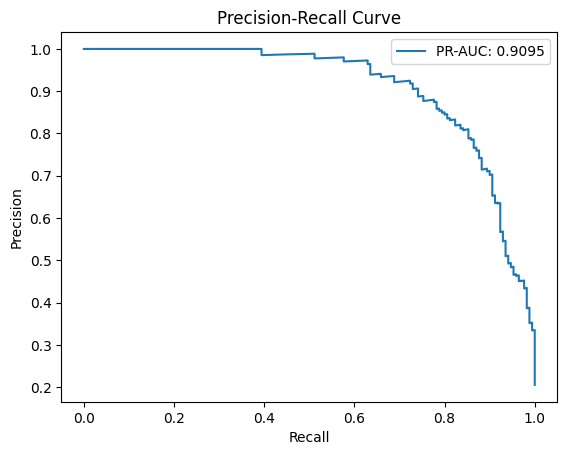

In [90]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(recall, precision, label=f"PR-AUC: {pr_auc:.4f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()